In [2]:
import os
import statistics
import json
import glob
from matplotlib import pyplot as plt
from posixpath import basename
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import matplotlib

In [3]:
discr_dict={'P1':0,'P2':1,'P3':2,'P4':3,'Q1':4,'Q2':5}
mesh_dict={"square_beam_0.050":0,"square_beam_0.025":1,"square_beam_0.022":2,"square_beam_0.021":3,"square_beam_0.020":4,"square_beam_0.019":5,"square_beam_0.016":6,"square_beam_0.013":7,"square_beam_0.010":8}
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
class Cal_result(object):
    # solver_name="AMGCL"
    # json_name="bar"
    # discr_order=1
    # n_ref=1
    # block_size=1
    # repeat_times=5
    # result_json=[]
    # time=np.zeros((1,repeat_times),dtype=np.double)
    # iter=np.zeros((1,repeat_times),dtype=np.int32)
    # err=np.zeros((1,repeat_times),dtype=np.double)
    def __init__(self,solver_name_,mesh_name_,json_name_,discr_order_,n_ref_,block_size_,repeat_times_):
        self.solver_name=solver_name_
        self.mesh_name=mesh_name_
        self.json_name=json_name_
        self.discr_order=discr_order_
        self.n_ref=n_ref_
        self.block_size=block_size_
        self.repeat_times=repeat_times_
        self.result_json=[None]*(repeat_times_+1)
        self.time=np.zeros((1,repeat_times_+1),dtype=np.double)
        self.iter=np.zeros((1,repeat_times_+1),dtype=np.int32)
        self.err=np.zeros((1,repeat_times_+1),dtype=np.double)
    def avg_time(self):
        return np.average(self.time,axis=1)
    def avg_iter(self):
        return np.average(self.iter,axis=1)
    def avg_err(self):
        return np.average(self.err,axis=1)



In [4]:
def get_erriter(solver_name_,json_data_): 
    #return iter,err(0 if not exist,-1 if fail)
    if solver_name_=="AMGCL":
        return json_data_["num_iterations"],json_data_["final_res_norm"]
    if solver_name_=="Eigen::CholmodSupernodalLLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Eigen::ConjugateGradient":
        return json_data_["solver_iter"], json_data_["solver_error"]
    if solver_name_=="Hypre":
        return json_data_["num_iterations"],json_data_["final_res_norm"]
    if solver_name_=="Eigen::PardisoLDLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Eigen::SimplicialLDLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1

In [5]:
def stats(j_file_): 
    #return solving_time,iterations,error
    with open(j_file_, 'r') as f:
        json_data = json.load(f)
    solver_name=json_data["args"]["solver_type"]
    tensor_formulation=json_data["args"]["tensor_formulation"]
    time_solving=json_data["time_solving"]
    num_iterations=0
    err=0
    solver_info=json_data["solver_info"]
    if tensor_formulation=="NeoHookean":
        err_list=[]
        iter_list=[]
        for temp in json_data["solver_info"][0]["info"]["internal_solver"]:
            tempiter,temperr=get_erriter(solver_name,temp)
            err_list.append(temperr)
            iter_list.append(tempiter)
        err=statistics.mean(err_list)
        num_iterations=sum(iter_list)
        return time_solving,num_iterations,err
    else:
        tempiter,temperr=get_erriter(solver_name,solver_info)
        return time_solving,tempiter,temperr
    # Add "if" for more problems                

# Prepare data

In [6]:
path_list=glob.glob("results/square/**/**/**/**/**/**")
start_index=2
result_list=[]
fail_list=[]
for path in path_list:
    temp_path=path.split('/')
    solver_name=temp_path[0+start_index]
    mesh_name=temp_path[1+start_index]
    if float(mesh_name.split('_')[-1])>0.050:
        continue
    json_name=temp_path[2+start_index]
    discr_order=discr_dict[temp_path[3+start_index]]
    n_ref=int(temp_path[4+start_index][-1])
    block_size=int(temp_path[5+start_index][-1])
    repeat_path=glob.glob(os.path.join(path,"*"))
    repeat_times=max(map(int,map(os.path.basename,repeat_path)))
    temp_result=Cal_result(solver_name,mesh_name,json_name,discr_order,n_ref,block_size,repeat_times)
    exist_bool=True
    for inner_path in repeat_path:
        repeat_time=int(os.path.basename(inner_path))
        json_path=os.path.join(inner_path,"json","result.json")
        if os.path.exists(json_path):
            temp_result.time[0,repeat_time],temp_result.iter[0,repeat_time],temp_result.err[0,repeat_time]=stats(json_path)
            temp_result.result_json[repeat_time]=inner_path
        else:
            fail_list.append(inner_path)
            # print(inner_path+" is empty, corresponding test failed")
            exist_bool=False
    if exist_bool:
        result_list.append(temp_result)

In [7]:
columns=["Scene","Solver","Mesh","discr_order","n_ref","block size","Runtime","Error","Iterations"]
result_df=pd.DataFrame(columns=columns)
for result,i in zip(result_list,range(len(result_list))):
    df_row={}
    df_row["Scene"]=result.json_name
    df_row["Mesh"]=result.mesh_name
    df_row["Solver"]=result.solver_name
    df_row["discr_order"]=result.discr_order
    df_row["n_ref"]=result.n_ref
    df_row["block size"]=result.block_size
    df_row["Runtime"]=np.average(result.time,axis=1)
    df_row["Error"]=np.average(result.err,axis=1)
    df_row["Iterations"]=np.average(result.iter,axis=1)
    result_df.loc[i]=df_row

# Plot

In [8]:
def search_result(solver_name_=None,mesh_name_=None,json_name_=None,discr_order_=None,n_ref_=None,block_size_=None):
    masks=np.ones_like(np.arange(len(result_list)),dtype=bool)
    for i in np.arange(len(result_list)):
        if masks[i]==0:
            continue
        else:
            if solver_name_!=None:
                if result_list[i].solver_name!=solver_name_:
                    masks[i]=0
                    continue
            if mesh_name_!=None:
                if result_list[i].mesh_name!=mesh_name_:
                    masks[i]=0
                    continue
            if json_name_!=None:
                if result_list[i].json_name!=json_name_:
                    masks[i]=0
                    continue
            if discr_order_!=None:
                if result_list[i].discr_order!=discr_order_:
                    masks[i]=0
                    continue
            if n_ref_!=None:
                if result_list[i].n_ref!=n_ref_:
                    masks[i]=0
                    continue
            if block_size_!=None:
                if result_list[i].block_size!=block_size_:
                    masks[i]=0
                    continue
    return_list=[]
    for i in range(len(result_list)):
        if masks[i]==True:
            return_list.append(result_list[i])
    return return_list


# Avg solving time

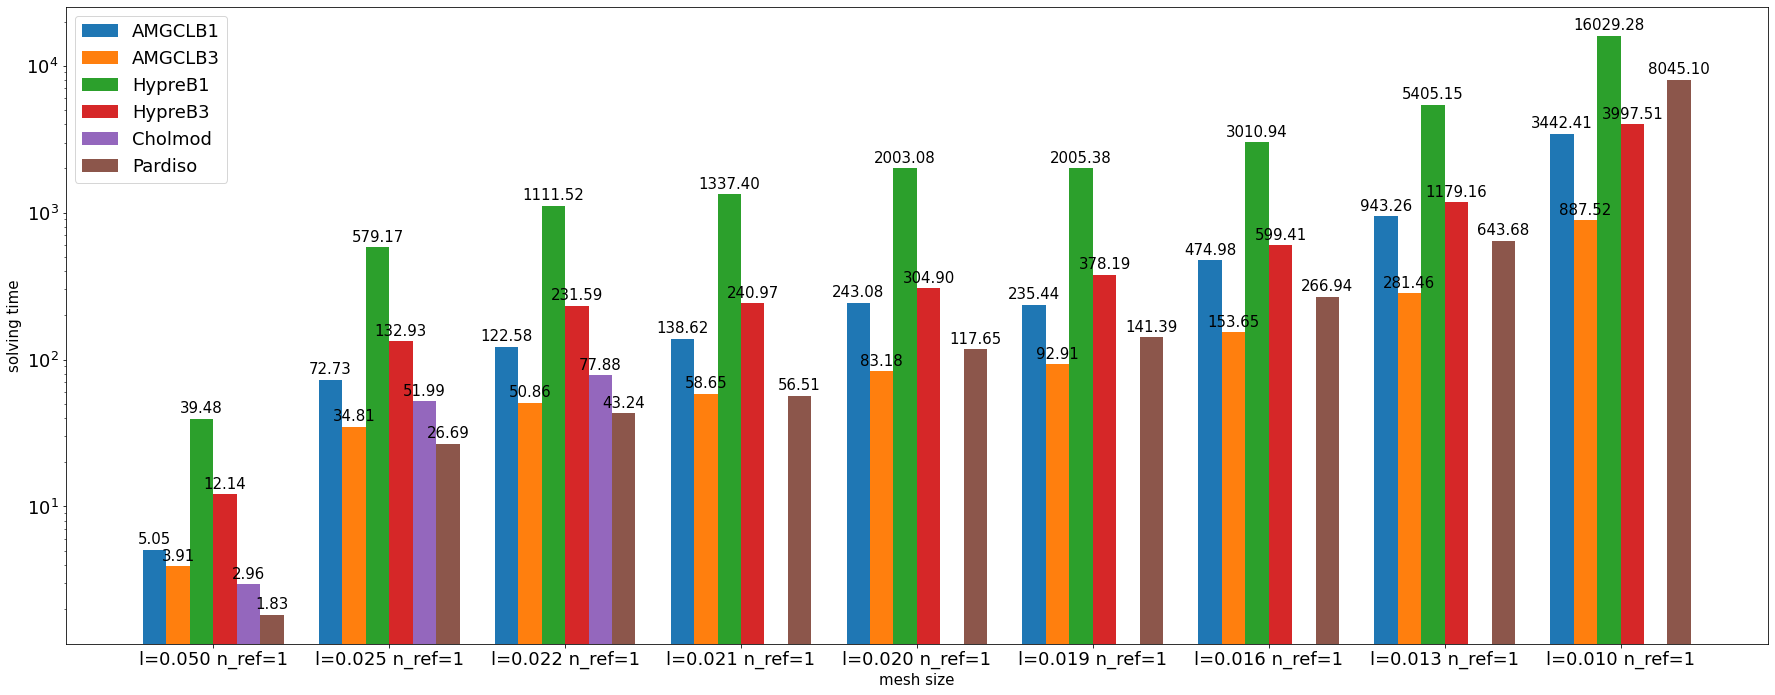

In [9]:
%matplotlib inline
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel("mesh size",fontsize=15) # x labels
ax.set_ylabel("solving time",fontsize=15) # y labels
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

# P2 ref0-1 
n_refs=[1]
discr_order=2
x_length=len(mesh_dict) # the number of x axis
labels=[] # X label
for i in range(len(mesh_dict)):
    for j in n_refs:
        temp_label="l="+list(mesh_dict)[i].split('_')[-1]+" n_ref="+str(j)
        labels.append(temp_label)
rect_lablels=["AMGCLB1","AMGCLB3", "HypreB1","HypreB3","Cholmod","Pardiso"]
num_rects=len(rect_lablels) # the number of rectangles 
x=np.arange(x_length) 
ax.set_xticks(x)
ax.set_xticklabels(labels)



data_list=[]
for i in range(2):
    temp_data=np.zeros(x_length)
    for n_ref in n_refs:    
        search_list=search_result("AMGCL",n_ref_=n_ref,json_name_="bar",discr_order_=discr_order,block_size_=1+2*i)    
        for result in search_list:
            temp_data[len(n_refs)*mesh_dict[result.mesh_name]+n_ref-n_refs[0]]=np.average(result.time,axis=1)
    data_list.append(temp_data)
for i in range(2):
    temp_data=np.zeros(x_length)
    for n_ref in n_refs:
        search_list=search_result("Hypre",n_ref_=n_ref,json_name_="bar",discr_order_=discr_order,block_size_=1+2*i)    
        for result in search_list:
            temp_data[len(n_refs)*mesh_dict[result.mesh_name]+n_ref-n_refs[0]]=np.average(result.time,axis=1)
    data_list.append(temp_data)
for i in range(2,4):
    temp_data=np.zeros(x_length)
    for n_ref in n_refs:
        search_list=search_result(solver_list[i],n_ref_=n_ref,json_name_="bar",discr_order_=discr_order,block_size_=1)    
        for result in search_list:
            temp_data[len(n_refs)*mesh_dict[result.mesh_name]+n_ref-n_refs[0]]=np.average(result.time,axis=1)
    data_list.append(temp_data)
for i in range(num_rects):    
    ax.bar_label(ax.bar(x-0.4+0.8/(num_rects)*(i+0.5),data_list[i],0.8/num_rects,label=rect_lablels[i]),padding=3,fmt='%.2f',fontsize=15)
ax.legend()

plt.yscale("log") # log scale
fig.tight_layout()
plt.show()

# Avg iterations

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (8).

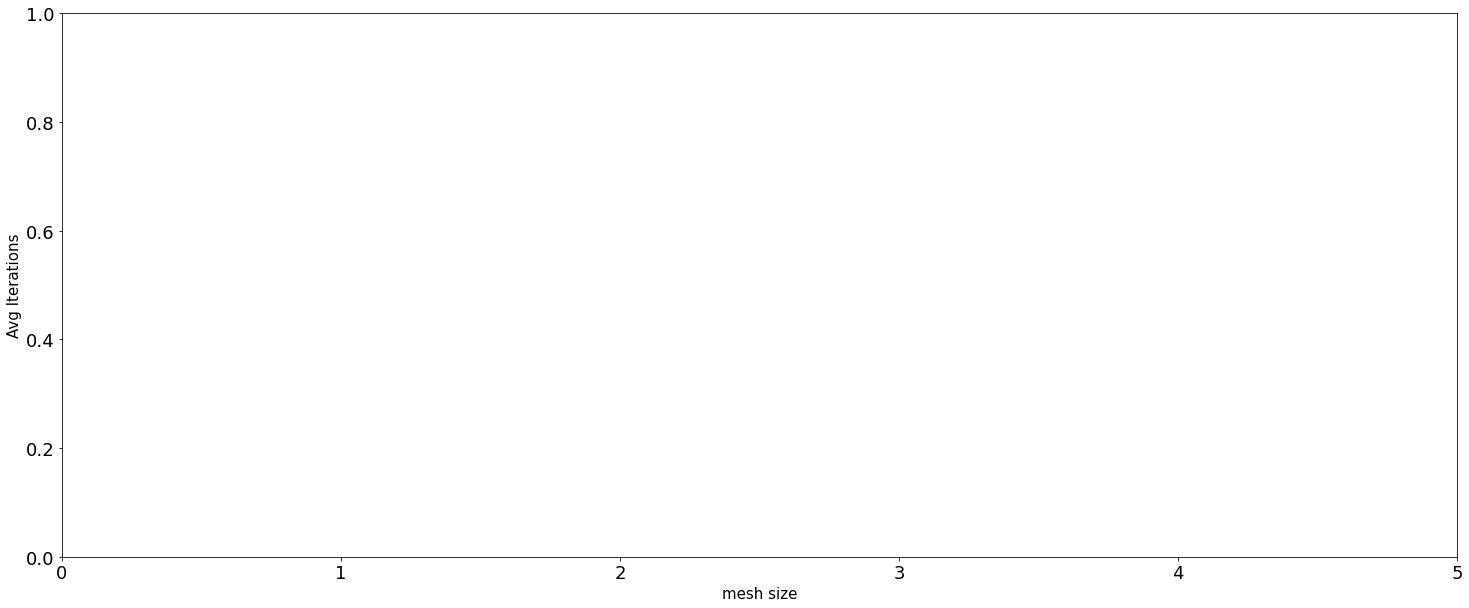

In [18]:
%matplotlib inline
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel("mesh size",fontsize=15) # x labels
ax.set_ylabel("Avg Iterations",fontsize=15) # y labels
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

# P2 ref0-2 
x_length=6 # the number of x axis
labels=[] # X label
for i in range(len(mesh_dict)):
    temp_label="l="+list(mesh_dict)[i].split('_')[-1]
    labels.append(temp_label)
rect_lablels=["AMGCLB1","AMGCLB3", "HypreB1","HypreB3"]#,"Cholmod","Eigen::SimplicialLDLT","Eigen::PardisoLDLT"]
num_rects=len(rect_lablels) # the number of rectangles 
x=np.arange(x_length) 
ax.set_xticks(x)
ax.set_xticklabels(labels)


data_list=[]
for i in range(2):
    search_list=search_result("AMGCL",n_ref_=1,json_name_="bar",discr_order_=2,block_size_=1+2*i)
    temp_data=np.zeros(x_length)
    for result in search_list:
        temp_data[mesh_dict[result.mesh_name]]=np.average(result.iter,axis=1)
    data_list.append(temp_data)
for i in range(2):
    search_list=search_result("Hypre",n_ref_=1,json_name_="bar",discr_order_=2,block_size_=1+2*i)
    temp_data=np.zeros(x_length)
    for result in search_list:
        temp_data[mesh_dict[result.mesh_name]]=np.average(result.iter,axis=1)
    data_list.append(temp_data)
for i in range(2,5):
    search_list=search_result(solver_list[i],n_ref_=1,json_name_="bar",discr_order_=2,block_size_=1)
    temp_data=np.zeros(x_length)
    for result in search_list:
        temp_data[mesh_dict[result.mesh_name]]=np.average(result.iter,axis=1)
    data_list.append(temp_data)
for i in range(num_rects):    
    ax.bar_label(ax.bar(x-0.4+0.8/(num_rects)*(i+1),data_list[i],0.8/num_rects,label=rect_lablels[i]),padding=3,fmt='%.1f',fontsize=18)
ax.legend(loc='best')


plt.yscale("log") # log scale
fig.tight_layout()
plt.show()

# Avg Error

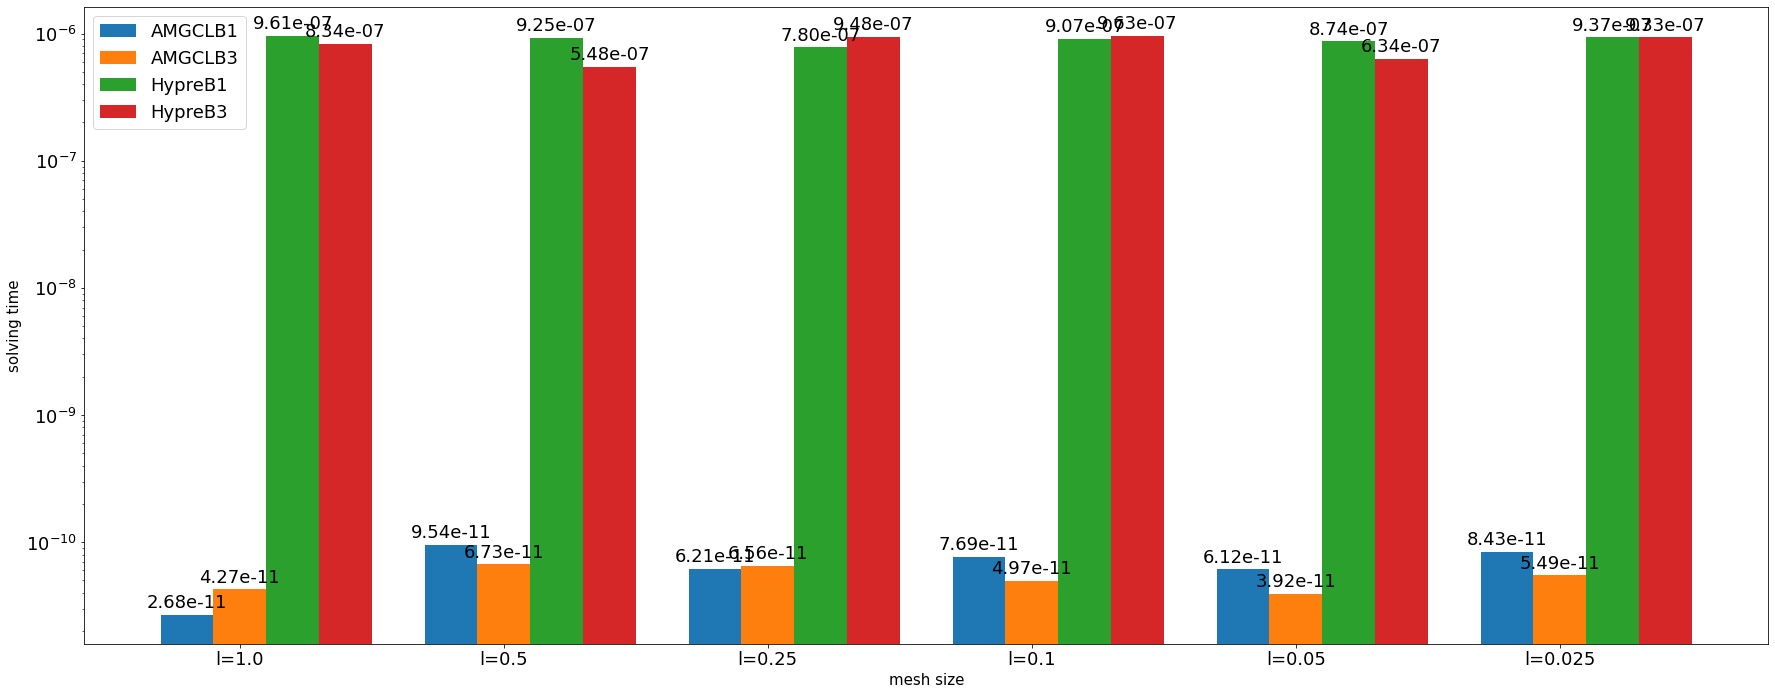

In [20]:
%matplotlib inline
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel("mesh size",fontsize=15) # x labels
ax.set_ylabel("Avg Error",fontsize=15) # y labels
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

# P2 ref0-2 
x_length=6 # the number of x axis
labels=[] # X label
for i in range(len(mesh_dict)):
    temp_label="l="+list(mesh_dict)[i].split('_')[-1]
    labels.append(temp_label)
rect_lablels=["AMGCLB1","AMGCLB3", "HypreB1","HypreB3"] #,"Cholmod","Eigen::SimplicialLDLT","Eigen::PardisoLDLT"]
num_rects=len(rect_lablels) # the number of rectangles 
x=np.arange(x_length) 
ax.set_xticks(x)
ax.set_xticklabels(labels)


data_list=[]
for i in range(2):
    search_list=search_result("AMGCL",n_ref_=1,json_name_="bar",discr_order_=2,block_size_=1+2*i)
    temp_data=np.zeros(x_length)
    for result in search_list:
        temp_data[mesh_dict[result.mesh_name]]=np.average(result.err,axis=1)
    data_list.append(temp_data)
for i in range(2):
    search_list=search_result("Hypre",n_ref_=1,json_name_="bar",discr_order_=2,block_size_=1+2*i)
    temp_data=np.zeros(x_length)
    for result in search_list:
        temp_data[mesh_dict[result.mesh_name]]=np.average(result.err,axis=1)
    data_list.append(temp_data)
for i in range(2,5):
    search_list=search_result(solver_list[i],n_ref_=1,json_name_="bar",discr_order_=2,block_size_=1)
    temp_data=np.zeros(x_length)
    for result in search_list:
        temp_data[mesh_dict[result.mesh_name]]=np.average(result.err,axis=1)
    data_list.append(temp_data)
for i in range(num_rects):    
    ax.bar_label(ax.bar(x-0.4+0.8/(num_rects)*(i+1),data_list[i],0.8/num_rects,label=rect_lablels[i]),padding=3,fmt='%.2e',fontsize=18)
ax.legend(loc='best')


plt.yscale("log") # log scale
fig.tight_layout()
plt.show()

# Avg solving time

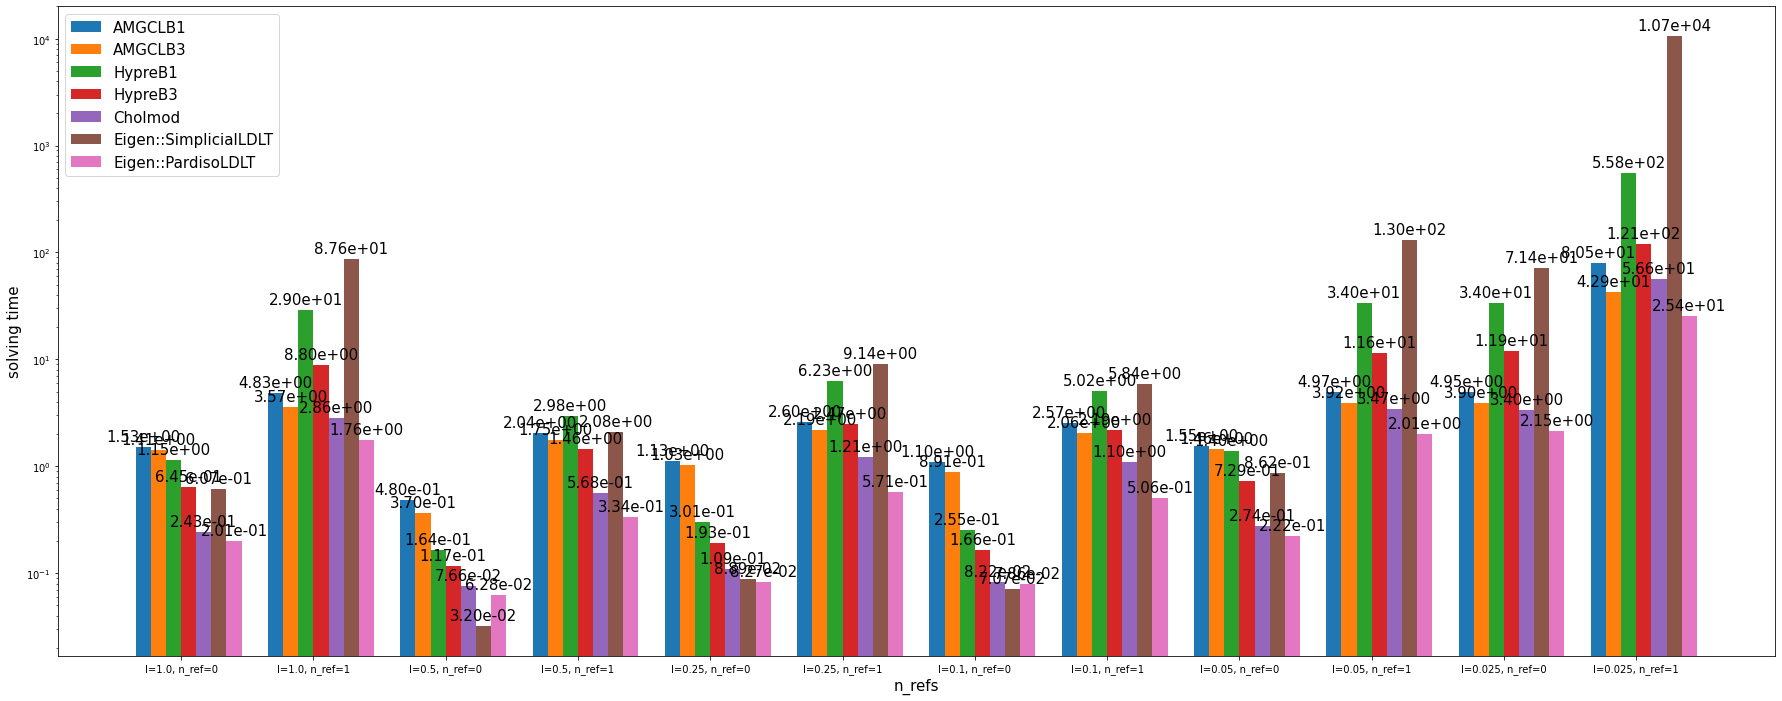

In [17]:
%matplotlib inline
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 15}) # font size
ax.set_xlabel("mesh_size",fontsize=15) # x labels
ax.set_ylabel("solving time",fontsize=15) # y labels

# P2 ref0-2 
x_length=12 # the number of x axis
labels=[] # X label
for i in range(len(mesh_dict)):
    for j in range(2):
        temp_label="l="+list(mesh_dict)[i].split('_')[-1]+", n_ref="+str(j)
        labels.append(temp_label)
rect_lablels=["AMGCLB1","AMGCLB3", "HypreB1","HypreB3","Cholmod","Eigen::SimplicialLDLT","Eigen::PardisoLDLT"]
num_rects=len(rect_lablels) # the number of rectangles 
x=np.arange(x_length) 
ax.set_xticks(x)
ax.set_xticklabels(labels)


data_list=[]
for i in range(2):
    search_list=search_result("AMGCL",json_name_="bar",discr_order_=2,block_size_=1+2*i)
    temp_data=np.zeros(x_length)
    for result in search_list:
        temp_data[2*mesh_dict[result.mesh_name]+result.n_ref]=np.average(result.time,axis=1)
    data_list.append(temp_data)
for i in range(2):
    search_list=search_result("Hypre",json_name_="bar",discr_order_=2,block_size_=1+2*i)
    temp_data=np.zeros(x_length)
    for result in search_list:
        temp_data[2*mesh_dict[result.mesh_name]+result.n_ref]=np.average(result.time,axis=1)
    data_list.append(temp_data)
for i in range(2,5):
    search_list=search_result(solver_list[i],json_name_="bar",discr_order_=2,block_size_=1)
    temp_data=np.zeros(x_length)
    for result in search_list:
        temp_data[2*mesh_dict[result.mesh_name]+result.n_ref]=np.average(result.time,axis=1)
    data_list.append(temp_data)
for i in range(num_rects):    
    ax.bar_label(ax.bar(x-0.4+0.8/(num_rects)*(i+1),data_list[i],0.8/num_rects,label=rect_lablels[i]),padding=3,fmt='%.2e')
ax.legend()

plt.yscale("log") # log scale
fig.tight_layout()
plt.show()